# Section III. MOTION PLANNING
    
# Chapter 9. Motion Planning in Simple Geometric Spaces


We will introduce the key issues involved in motion planning in a
simple, illustrative *planar path planning* setting. Here, the robot
consists only of a point, moving in 2D in an environment with polygonal
obstacles. Later we will extend this to handle robots with geometry that
can translate and rotate. Planar path planning is useful for a number of
applications involving mobile ground robots, autonomous boats, and
defining waypoints for aerial vehicles. It is also useful for providing
coarse guidance paths for legged robots and mobile manipulators.

In motion planning, it is impossible for an algorithm to consider the
continuous infinity of paths in the free space. So, the main question to
ask is how can an algorithm get away with considering a finite number of
alternatives when the true number of alternatives is infinite? What must
be sacrificed?

In the 2D context, we have the relative luxury of having a polygonal
representation of C-obstacles (but not necessarily the free space),
which provides much richer geometric information than in the
high-dimensional problems we will consider in the next section. We will
consider three classes of algorithm: bug algorithms, roadmap planners,
and cell decomposition planners.

*Bug algorithms* are interesting because the robot only needs local
information about the shape of obstacles, and a small amount of memory,
to achieve the goal. They can therefore be executed on simple robots
without knowledge of all of the obstacles in the space. However, they
can be extremely inefficient. *Roadmap planners* build a network of
paths in free space. Once a network is constructed, a graph search
algorithm can be invoked to yield a solution path. *Cell decomposition
planners* also build a network, but a network of adjacent regions in
free space. In both roadmap and cell decomposition planners, the manner
in which the graph is constructed dictates the performance,
completeness, and solution quality of the algorithm.

These planners can largely be extended to robots that contain some
geometry and can translate and rotate on the plane. We will describe
some extensions of these techniques to generate smooth motions, which
are applicable to car-like mobile robots and aerial vehicles that cannot
rotate in place.

Bug algorithms
--------------

Bug algorithms are simple, clever planning methods that do not actually need a map of obstacles to work!  The only pieces of information needed on-board the robot are 1) a way to determine the robot's current location $X$ and goal location $G$, 2) a contact sensor, and 3) a bit of memory.  By studying how the robot would behave in certain maps, this give us a sense of how to analyze the performance of planners. 

The inspiration for bug algorithms comes from the _right-hand rule_ for solving mazes. If you are in a maze, a sure-fire way not to get lost is to find a wall, face a direction so that the wall is on your right, and walk along the wall while keeping it immediately to your right.  By following this process, only two possibilities may result: 1) you exit the maze, or 2) you return to the point at which you first touched the wall.  If you return to the starting point, the wall makes a closed circuit, so the next step should be to find a new portion of wall that you did not touch, and apply the right-hand rule again for that new wall.  Using this approach, you are guaranteed to explore the entire maze.  (There is no significance to right vs left; you can just as easily apply a _left-hand rule_.)

The first method we will study is called Bug 1.  Unlike the case of a maze, in planning we know which direction we would need to take to reach the goal.  So, Bug 1 proceeds as follows:

*************
<a name="alg:Bug1"></a>
**Algorithm Bug 1**

1. Move in a straight line path toward $G$.

2. If the robot reaches $G$, we are done.  

3. If the robot hits an obstacle, then follow the right-hand rule and traverse its boundary 

4. This continues until the wall no longer is pointing against the straight line from $X$ toward $G$.  Once this occurs, continue from Step 1.
**************

It is important to note that in Step 4, this determination is done only locally.  It does not examine the overall shape of the obstacle to see if the straight line does not overlap the obstacle, only locally whether taking the direction $G-X$ leads the robot into free space. 

*************

![fig:Bug0](figures/planning/bug0.svg)

<div class="figcaption"><a name="fig:Bug0">Figure 1</a>.
    The simple Bug 1 algorithm that simply 1) heads toward the goal, 2) turns
left when it hits an obstacle, and proceeds to hug the wall, and 3) continues towards the goal
    whenever it can.
</div>

*************

The second method is called Bug 2, and is a little more complex.  Here, we shall add some memory to the robot.

*************
<a name="alg:Bug2"></a>
**Algorithm Bug 2**
1. Move in a straight line path toward $G$. 

2. If the robot reaches $G$, we are done.  

3. If the robot hits an obstacle, remember the point $P$ at which it is hit.  Follow the right hand-rule.

4. If the robot crosses the line $\overline{PG}$ as it walks along the wall, determine whether $\| X-G \| < \|P-G\|$ and the wall is not pointing against the straight line from $X$ toward $G$.  If both conditions are satisfied, continue from step 1.  Otherwise, keep walking.

5. If $P$ is reached again, return "No path"
*************

Fig. 2 shows how this algorithm works.

*************

<a name="fig:Bug2"></a>
![fig:Bug2](figures/planning/bug2.svg)

<div class="figcaption">Figure 2.
    The Bug 2 algorithm remembers the line from the start to the
goal, and circumnavigates an obstacle until it meets the line again at a
closer point to the goal.
</div>


*************

Bug 1 might seem at first to be a little more efficient than Bug 2, because it will opportunistically move in a straight line toward the goal whenever it can break away from the obstacle.  Bug 2 has to hug the boundary of an obstacle until it reaches the line $\overline{PG}$ again.  However, the problem in Bug 1 is that it may fall into an _infinite loop_, as shown in Fig. 3.  Here, the obstacle is set up so that the robot breaks away from the obstacle, only to hit it again.

*************

<a name="fig:Bugtrap"></a>
![fig:Bugtrap](figures/planning/bugtraps.svg)

<div class="figcaption">Figure 3.
    A "bugtrap" environment designed so that Bug 1 falls into an infinite
loop, while Bug 2
succeeds.
</div>

*************

By contrast, Bug 2 delays breaking away from the obstacle, which traverses a longer length of the obstacle boundary. In this example, the breakaway point is chosen more judiciously to avoid the infinite loop.  But this is only an anecdote; can we _prove_ that Bug 2 will always succeed (i.e., is a complete planner)?  It turns out that we can.

To prove completeness of Bug 2, we shall need to establish 3 facts:

A. For each obstacle, Bug 2 will break away from it at some point if there is a path to the goal.

B. The sequence of hit points decreases in distance to the goal.

C. If there is no path to the goal, then Bug 2 will terminate correctly with failure.


Let $O$ be a connected, bounded, planar obstacle, and $P$ any location at which Bug 2 hits it.  Now consider the  curve $\partial O$ traversed by the right hand rule.  This curve will be the boundary of $O$ if $O$ contains zero holes, but if $O$ contains holes then it will be some connected component of its boundary.  $\partial O$ is a closed curve dividing the plane into two connected components, and a fact of plane geometry is that a closed curve $C$ separates two points $A \notin C$ and $B \notin C$ iff $\overline{AB}$ intersects $C$ in an odd number of points.  Let $P^\prime$ be the point immediately preceeding $P$ on the robot's path.  We know that $P^\prime \notin O$, and $\|P^\prime - G \| > \|P-G\|$, because Bug 2 only moves toward the goal, never away from it.   So, if there is a path to the goal, then the line $\overline{P^\prime G}$ intersects $\partial O$ an even number of times.   Hence, there is at least one other intersection point other than $P$.  Let $C$ be the closest intersection point.  The line segment between $C$ and $G$ will be pointing away from $O$, hence, we know that $C\neq P$ since the line from $P$ to $G$ points into $O$.  Hence, the robot must break away at from $\partial O$ at some closer point.  This establishes fact A.

Second, let $L$ be the point at which the robot leaves obstacle $O$.  If the robot hits another obstacle, it will have traveled in a straight line from $L$ to $G$, so its next hit point $P^\prime$ is closer to $G$ than $L$.  Since $\|P - G \| > \| L - G \| > \|P^\prime - G\|$, the sequence of hit points are decreasing in distance, establishing fact B.

Finally, we need to establish that termination at Step 5 correctly determines that no path exists.  As established in B, the sequence of hit points has decreasing distance, so an infinite loop is not possible: Bug 2 must either find the goal or terminate with "No path".  As established in A, "No path" will not be returned if there is a path to the goal. By contradiction, returning "No path" implies there is no path to the goal.  QED.

Roadmap planners
----------------

Roadmap planners are able to achieve higher quality paths than bug
algorithms, but require advance knowledge of all obstacles. They operate
by computing a graph $G$ where vertices indicate free configurations and
edges indicate collision-free paths (usually straight lines). Then,
graph search is performed on this structure to produce a free path. See
[Appendix C.1](GraphSearch.ipynb) for more information about graph search
algorithms.

### Grid search



A straightforward method for planning paths in 2D is grid search. Let us
define the graph $G$ such that all vertices lie on a grid, and all edges
are vertical or horizontal and connect subsequent vertices. Let us
assume that $s$ and $g$ lie directly on grid vertices. If we remove all
vertices from the grid that are contained within obstacles, and remove
edges that intersect obstacles, then a search on the remaining graph
will yield a path from the start to the goal
([Fig. 4](#fig:Grid4)).

****************

![fig:Grid4](figures/planning/grid4.svg)

<div class="figcaption"><a name="fig:Grid4">Figure 4</a>.
    Searching along a grid is a resolution complete
method.
</div>

****************

If the grid has $m$ divisions in the $x$ direction and $n$ divisions in the $y$ direction, then there are at most $mn$ vertices in the grid.  As discussed in [Appendix C.1](GraphSearch.ipynb), the running time of Dijkstra's algorithm will be $O(mn \log mn)$.

There are two main issues with grid search. First, if the obstacles are
constructed to contain *narrow passages* smaller than the resolution of
the grid, then it is unlikely for the graph to contain a feasible path
even if one exists in the continuous space (unless we are lucky and the
narrow passage lines up with the grid edges). The solution to this
problem is to increase the resolution of the grid until it is
sufficiently fine to find a path through the narrow passage, as shown below.

****************

![fig:NarrowPassageGrid](figures/planning/narrow_passage_grid.svg)

<div class="figcaption"><a name="fig:NarrowPassageGrid">Figure 5</a>.
    (Left) A grid search is very likely to fail if the robot needs to pass
through a narrow passage smaller than the grid resolution. (Middle) The
clearance of a path is the minimum distance to obstacles of any point on
the path. (Right) If there exists a path with clearance at least
$d \geq h/\sqrt{2}$ away from obstacles, then a grid planner with
resolution $h$ will find a
path.
</div>

****************


To make this more rigorous, let us denote the *clearance* of a point as
the distance to the nearest obstacle, and the clearance of a path to be
the minimum clearance of all points along the path. It can be easily
shown that if there *exists in the free space* a path with clearance at
least $h / \sqrt 2$, then search on a grid with resolution $h$ will find
a feasible path. Hence, grid search is resolution-complete.


The second issue is that the grid does not contain shortest paths in the
original space. Any diagonal movement can only be approximated by a
series of axis-aligned movements, which is suboptimal regardless of the
resolution of the grid. To partially mitigate this suboptimality, four
$45^\circ$ diagonal edges between grid cells may be added with cost
$h \sqrt 2$. For an even better result, the 8 diagonal edges passing two
cells on each axis (moving in directions (2,1) (1,2), (-1,2), etc.) can
be added to the graph. The drawback of adding additional edges is that
more edges must be checked for collision when constructing the graph.


****************

![fig:Grid8](figures/planning/grid8.svg)

<div class="figcaption"><a name="fig:Grid8">Figure 6</a>.
Searching with 8-connected grid points allows the planner to compute
slightly shorter paths.
    </div>

****************

Techniques that address these problems include the Any-Angle A\* and the
Fast Marching Method (FMM). Both of these methods perform the
propagation of distances to a vertex's neighbor not only using the cost
of the path along the edge, but also via off-edge paths. Any-Angle A\*
maintains information at each vertex about the source of straight line
cost accumulation, while FMM approximates path costs via interpolation
of the costs of any other explored vertices in adjoining grid cells. A
complete description of these methods is beyond the scope of this book,
but suffice to say the approximation quality of both methods improves
with finer grids.



### Visibility graph

****************

![fig:VisibilityGraph](figures/planning/visibilitygraph.svg)

<div class="figcaption"><a name="fig:VisibilityGraph">Figure 7</a>.
Illustrating the visibility graph method. First, edges from each
vertex to every other vertex are added if collision free. Next, the
visibility graph is completed. Finally, a shortest path is produced via
graph search.
    </div>
    
****************

The *visibility graph* method was one of the earliest motion planning
algorithms and is also notable because it is a *complete, optimal*
algorithm for polygonal obstacles. The idea of the visibility graph is
to construct a graph whose vertices are the start, goal, and all
obstacle vertices, and the edges consist of all possible collision-free
line segments and obstacle edges. As a result, the solution paths will
pass directly through obstacle corners.  Pseudocode for the basic visibility graph method is given below.

*************
<a name="alg:VisibilityGraph"></a>
**Algorithm Visibility-Graph**

1. Let $V \gets \{ s, g \}$ and all obstacle vertices.
2. $E \gets \{ \}$.
3. **for** all pairs of distinct vertices $u, v \in V$
4. &nbsp;&nbsp;&nbsp;**if** $\overline{uv}$ is an obstacle edge
5. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Add $(u,v)$ to $E$.
6. &nbsp;&nbsp;&nbsp;**else if** $\overline{uv}$ is collision free
7. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Add $(u,v)$ to $E$.
8. Search $G = (V,E)$, with Cartesian distance as the edge cost, to connect $s$ and $g$.
9. **return** the path if one is found.

*************

The number of iterations of Line 3 is
O($n^2$) where $n$ is the number of obstacle vertices. Line 6 requires
collision checking an edge with all other obstacle edges, which is an
O($n$) operation. Overall, this brute-force construction visibility
graph is constructed in O($n^3$) time. Proving the correctness and
optimality of this planner is left as an exercise.

Because $n$ may be quite large, e.g., in the hundreds or thousands, it
may be fruitful to reduce the computational complexity of this
algorithm. First, we can observe that if two convex obstacles have many
intermediate vertices, most of the possible edges between them cannot be
a part of an optimal path. Only the edges connecting obstacle tangents
--- that is, an edge such that the prior and next obstacle vertex are on
the same side of the edge --- need be checked for collision. Second, we
can check for collisions between related edges in a more efficient way.

One method for doing so is known as the rotational sweep. The rotational
sweep methods collision checks all outgoing edges from a given vertex
$u$ in $O(n \log n)$ time by tracking the closest obstacle edge as a ray
centered at $u$ sweeps around the full circle. The procedure is as
follows:

1.  Sort all vertices around $u$ in order of increasing rotational
    angle. Ties are broken by closest distance. $O(n \log n)$ time.

2.  For the vertex $v$ with minimum angle, perform a collision check
    with the infinite ray from $u$ toward $v$. Order all of the edges
    $I = (e_1,\ldots,e_k)$ intersected by the ray by order of increasing
    distance. If $v$ is on the closest edge, add the edge $(u,v)$ to
    $E$. $O(n + log n)$ time.

3.  Proceed to the next vertex $w$ in the sorted list. If $w$ is the end
    of edge $e_1$, add $(u,w)$ to $E$ and remove $e_1$ from $I$. If it
    ends any other edge $e_k \in I$, remove it from $I$. If $w$ is the
    start of any edge $e \notin I$, then add it to $I$ in order of
    intersection distance. With binary search to identify edges in $I$,
    this takes $O(\log n)$ time.

4.  Repeat Step 3 until all vertices are visited.

Overall, the rotational sweep method constructs the visibility graph in $O(n^2 \log n)$ time, since the above procedure must be repeated for each of the $n$ vertices.

Cell decomposition
------------------

The class of *cell decomposition* methods differs from the above
techniques in that the graph does not characterize a network of
configurations, but rather the connectivity between free-space regions
that meet at their boundary. So, once a cell decomposition is created,
we can identify the cells containing the start and goal configurations
and then search the graph to find a sequence of cells that contains a
feasible path.

### Trapezoidal decomposition

One of the simplest cell-decomposition methods is the *trapezoidal
decomposition*. This method divides free-space into trapezoids by
imagining vertical upper and lower edges emanating from each obstacle
vertex. The remaining cells are trapezoids and triangles, which are
degenerate trapezoids with one edge of length zero. Each cell that
borders another with a vertical line can be connected together with an
edge in the graph. Because each cell is convex, any line connecting the
left and right edges of the cell is also in free space.

****************

![fig:TrapezoidalDecomposition](figures/planning/trapezoidal.svg)

<div class="figcaption"><a name="fig:Trapezoidal">Figure 8</a>.
Illustrating the trapezoidal decomposition method. The division of free space into trapezoids and triangles creates a decomposition of the space into convex regions, connected by their vertical boundaries.  More useful for planning is the boundary graph, where nodes are midpoints of the vertical boundaries of each trapezoid, and edges connect any nodes touching the same trapezoid. The start and goal locations can be connected to the graph by identifying which trapezoid in which they lie, and connecting the vertex to each edge bordering the trapezoid.
    </div>
    
****************

To create a trapezoidal decomposition, a *sweep line algorithm* can be used. 
This method imagines a vertical line passing between vertices from
left to right, and cells are output incrementally. First we order all of the
obstacle vertices in increasing $x$ coordinate. Ties are broken by $y$ coordinate.  This approach is known as *lexicographical order*, in which $(x,y) \prec (x^\prime,y^\prime)$ iff either $x < x^\prime$, or ($x=x^\prime$ and $y<y^\prime$).  Let us assume this order is $v_1,\ldots,v_n$, with $v_i=(x_i,y_i)$.

The algorithm proceeds by moving the sweep line from $v_1$ to $v_2$, $v_2$ to $v_3$, and so on. At every vertex $(x_i,y_i)$, the algorithm maintains an *invariant* that all free-space segments through the vertical line passing through $x_i$ are maintained in a list $L$.  Each segment is an interval $[a,b]$, and each endpoint of the interval stores the edge to which it belongs (i.e., $e_a$, $e_b$).  Each interval is sorted in terms of increasing y coordinate.  Let's assume that the free space is bounded. In this case, we initialize $L$ with the interval $[y_1,y_1]$ with endpoints associated with the edges emanating from the bottom and top of $v_1$, respectively.  

Proceeding to the next vertex, one of three events may happen. 1) the next vertex may end *one* of the edges in $L$, simply *continuing* on to another cell, 2) the next vertex may *split* an
existing cell, 3) the next vertex may *birth* a new cell, or 4) the next vertex may end *two* of the edges in $L$, causing two cells to
*merge*.  Each operation modifies $L$ and outputs at most one cell.
- *Continue*: output one cell either above or below the ended edge, remove that edge from $L$ and
then insert the next edge in the same place as the old one. 
- *Split*: identify the location in $L$ into which the two new edges should be inserted.  A cell is outputted, bounded by the two edges surrounding the insertion position, and the two new edges are inserted there.
- *Birth*: the vertex arises from within an obstacle. An singleton interval is added to $L$, with edges emanating above and below the vertex.
- *Merge*: output the cell bounded below and above by the ended edges, and remove the edges from $L$. 


****************

![fig:SweepLine](figures/planning/sweep-line.svg)

<div class="figcaption"><a name="fig:SweepLine">Figure 9</a>.
Illustrating the types of events that can occur when a sweep line meets a vertex: (a) continue, (b) split, (c) birth, (d) merge.  The sweep line passes from left to right.  Blue edges are those on the sweep line that are unchanged; red edges are deleted; green edges are added.
    </div>
    
****************

This repeats until all vertices are processed. To maintain the
connectivity of the cell decomposition, we can remember the rightmost
cell added above or below each edge, and when a new cell is created, it is
attached to the previous cell associated with that edge, and the
rightmost cell is changed to the new cell.  (If the free space is unbounded, we produce an unbounded trapezoid to the left of the first vertex and to the right of the last vertex.)

Note that there are a fair bit of bookkeeping and technical details required to implement this properly, e.g., to trace the boundary of the free space, determine the event type, and maintain the connectivity of the decomposition. But we can still establish the key computational bottlenecks.  First, we must sort the points in lexicographic order, which takes time $O(n \log n)$.  The sweep line algorithm passes through $n$ points, and either a continue, split, or merge operation must be performed for each point. To look up the interval in which the new point is located takes $O(\log n)$ time using bisection, and the update and cell creation steps take O(1) time.  Overall, the running time is $O(n \log n)$.

To find a path given a trapezoidal decomposition, it suffices to find the cells in which the start and goal are located, then search for a path containing the start and goal.  The continuous path is constructed by connecting the midpoints between each cell. Because each path segment is completely contained within the cell, and because trapezoids are convex, the path is guaranteed to be feasible.  Hence, the trapezoidal decomposition algorithm is complete but not optimal.
Simple modifications of the vertical coordinates
 --- straightening the path when possible --- can be made to find the
shortest path passing through the cells produced by the algorithm.  However, the sequence of cells may indeed miss the true shortest path.

### Approximate cell decomposition

Exact cell decomposition algorithms have been extended to 3D spaces with polyhedral obstacles, but in general require sophisticated geometric reasoning about how the free space is cut into convex polyhedra.  An alternative technique is *approximate cell decomposition*, in which we do not worry about creating a decomposition of the true free space, but rather create cells that are contained in the free space.

One possible approach is that of an *octree*, which progressively subdivides the space into progressively smaller cubes until it can be determined that 1) a cube is *free*, i.e., completely within free space, 2) a cube is *closed*, i.e., completely inside an obstacle, or 3) a cube is smaller than a given resolution.  If a cube is neither free nor closed, it is *mixed*, and will be subdivided if it is larger than that resolution. An octree is constructed recursively, starting with a box $B_0$ that is know to contain the free space.  It proceeds by recursion on all boxes at level $i$. If a box is found to be mixed, then it is subdivided along each axis, which gives 8 child cubes (and hence the oct- prefix).


****************

![fig:SweepLine](figures/planning/octree.svg)

<div class="figcaption"><a name="fig:Octree">Figure 10</a>.
An octree cell decomposition progressively divides an initial bounding cube $B_0$ into smaller cubes $B_{1a}$--$B_{1h}$.  A cube does not need to be subdivided if it is completely within the free space, or if it is completely contained within obstacles.  The right figure shows two levels of subdivision, with free cubes in white, obstacle cubes darkly shaded, and mixed cubes lightly shaded.
    </div>
    
****************

Some more details are warranted on the collision checking step.  Suppose that obstacles are represented by triangle meshes. Then, if any triangle in the mesh overlaps the box, then the box is mixed.  Otherwise, the box is either free or closed.  It is somewhat difficult to tell whether the box is contained entirely inside an obstacle, but this case can be more or less safely ignored --- if our decomposition only contains free or closed cells, it cannot be the case that any free cell will be connected to any closed cell.

Once the octree is constructed, it is a matter of bookeeping to connect each non-mixed cell to its non-mixed neighbors, because on each of the 6 faces of a cell, the neighboring cell(s) may be at a finer level or a coarser level.  In this decomposition, if two free cells are connected, then there is certainly a free space path between them.  However, if two free cells are not connected, it is not certain whether a free space path exists.  Like grid search, this is a resolution complete method, because if the minimum resolution shrinks below a threshold (based on the clearance), then any free path connecting two points will correspond to a sequence of cells in the decomposition.


Extensions to planar robots with geometry
-----------------------------------------

Now let us consider the robot to have some geometry, and allow the robot
to translate and rotate in the plane. We will show that if we were to
convert the workspace obstacles into C-space obstacles, then we can
*directly* apply the techniques for point robots described above! This
forms the basis of most planar robot motion planning techniques. This
section will also describe how to handle rotations and more realistic
motion constraints.

### C-space obstacles

For each obstacle $O$ in the workspace, there exists a corresponding set
$\mathcal{C}O$ called the *C-obstacle* that contains all configurations
in which the obstacle collides with the robot. In other words,
$$\mathcal{C}O = \{ q  \in \mathcal{C} \,|\, R(q)\cap O \neq \emptyset \}.$$
The forbidden region can then be stated as the *union* of all
C-obstacles:
$$\mathcal{C} \setminus \mathcal{F} = \bigcup_{O \in E} \mathcal{C}O.$$
But can each $\mathcal{C}O$ be computed? Certainly this may be a
nontrivial problem, particularly when $dim(\mathcal{C})$ is large,
because it is not even clear how to represent a high dimensional set. We
show that in some cases, we can compute C-obstacles, and in others, it
is worth leaving a C-obstacle purely as an element of thought.

### Planar translating disks

For point-robots, determining a C-obstacle is trivial. If
$\mathcal{C} = \mathbb{R}^2$, and the space occupied by the robot $R(q)$
is simply the point $\{ q \}$, then the C-space obstacle $\mathcal{C}O$
corresponding to an obstacle $O \subseteq \mathbb{R}^2$ is simply
$\mathcal{C}O = O$ itself. Given obstacles $O_1,\ldots,O_n$, the
forbidden region is then simply the union $\bigcup_{i=1}^n O_i$. If the
obstacles overlap, we may calculate a representation of the boundary of
the union using constructive solid geometry (CSG) operations.

Let us now consider the case in which the robot is a translating disk
with radius $r$. The configuration $q$ denotes the translation of the
robot with respect to some reference frame, and without loss of
generality we choose this to have its origin at the center of the disk.
Given some obstacle $O$ in workspace, the C-space obstacle
$\mathcal{C}O$ is the set of points such that *if the center of the disk
is placed at that point, then the disk overlaps the obstacle.* This is
equivalent to the set of points within radius $r$ of the obstacle:
$$\mathcal{C}O = \{ q \,|\, D(q,r) \cap O \neq \emptyset \} = \{ q \,|\, dist(q,O) \leq r \}$$
where $D(q,r) \subseteq \mathbb{R}^2$ is the disk centered at $q$ with
radius $r$. In other words, it is a uniformly "fattened" version of the
workspace obstacle.

****************

![fig:DiskCObstacle](figures/planning/disk_cobstacle.svg)

<div class="figcaption"><a name="fig:DiskCObstacle">Figure 11</a>.
(a) For a disk robot and polygonal workspace obstacles, (b) the
corresponding C-obstacles are polygons "fattened" by the robot's radius
$r$. (Top) If the obstacle is convex, the C-obstacle is determined by
tracing arcs at every vertex. (Bottom) If the obstacle is non-convex,
the C-obstacle may contain
holes.
    </div>

****************

If $O$ is a convex polygon, then the boundary of the C-obstacle consists
of a series of circular arcs and straight lines
([Fig. 11](#fig:DiskCObstacle)). To construct the boundary, we may start
with any vertex $u$ of the polygon, and place a point offset
perpendicularly to its outgoing edge $\overline{uv}$. Tracing a straight
line parallel to that edge until it is perpendicular to the next vertex
$v$, we construct one edge of the C-obstacle. The next segment is a
circular arc of radius $r$, swept about $v$ until it hits the point
perpendicular to $v$'s outgoing edge. This continues around the boundary
of the polygon until the process returns to $u$.

In the non-convex obstacle case, the boundary is not so straightforward
to compute, because 1) for concave obstacle vertices, the straight edges
meet prematurely creating a concave vertex of the C-obstacle, and 2) the
boundary created by walking along the polygon in this manner may
self-intersect and even create inner holes. To properly handle the case
where holes exist requires some CSG-like techniques.

To plan in the presence of C-obstacles with arcs, you could discretize
the arcs into small polyhedral segments and use the techniques described
above for polygons. Or, you could modify the algorithms described above
to handle arcs directly. For example, a visibility graph with arcs would
construct graph segments consisting of 1) straight lines along obstacle
boundaries, 2) arcs along obstacle boundaries, or 3) straight lines that
are tangent to two arcs.

### Minkowski sums and differences

We can generalize the construction of C-obstacles to general translating
robots using the notion of a Minkowski difference. The *Minkowski sum*
$\oplus$ is a generalization of addition to be defined on sets of
points. If $A$ and $B$ are sets, then $A \oplus B$ is defined as the
set:
$$A \oplus B \equiv \{ x + y \,|\, x\in A \text{ and }y\in B\}.$$
Similarly, the Minkowski difference $\ominus$ is defined as
$$A \ominus B \equiv \{ x - y \,|\, x\in A \text{ and }y\in B\}.$$

If the reference frame of the robot is a shape $R_0$, then the volume
occupied after translation $q$ is the set
$$R(q) = \{ x \,|\, x-q \in R_0 \}$$ If $P$ is a workspace
obstacle, the the condition that $R(q) \cap O \neq \emptyset$ requires
that there exists some $x \in \mathbb{R}^2$ such that $x \in R(q)$ and
$x \in O$. This is equivalent to the condition that:
$$q \in O \ominus R_0.$$ To see this, observe that if
$q \in O \ominus R_0$, then there exists $x \in O$ and $y \in R_0$ such
that $q = x - y$. In other words, $y = x-q \in R_0$ implies that
$x \in R(q)$. As a result, constructing the C-obstacle is equivalent to
compute the Minkowski difference of the object minus the robot's
reference shape.

As an example, consider a convex polygonal robot with reference
$A=(a_1,\ldots,a_m)$ and a convex polygonal obstacle
$B = (b_1,\ldots,b_n)$. The Minkowki sums which can be obtained by 1)
flipping $A$ about the $x$ and $y$ axes to obtain $-A$, 2) tracing the
flipped shape about the edges of $B$, and 3) determining the outer edges
of the traced paths.

In the convex case, the C-obstacle can be shown to be convex with at
most $m+n$ edges. One brute-force way to compute it is to calculate all
extrema $a_i + b_j$, $i=1,\ldots,m$ and $j=1,\ldots,n$, and then
computing the convex hull. With an appropriate convex hull algorithm,
this can take $O(mn \log mn)$ time. There is however an optimal
$O(m + n)$ algorithm that constructs the Minkowski sum. Briefly, this
technique marches about the edges of each polygon and outputs an
extremal vertex for each vertex of either polygon encountered in CCW
order. In the general non-convex case, however, the Minkowski sum may
have $O((mn)^2)$ complexity, and may have holes.

### C-obstacles for rotational motion

C-obstacles for rotational motion are much more complex. Consider, for
example, a translating and rotating convex polygon with polygonal
obstacles. The C-space is SE(2) and consists of configurations
$q=(x,y,\theta)$. Imagine it as a volume with $\theta \in [0,2\pi)$ the
vertical axis.

Then, for any fixed rotation $\theta$, if we were to consider only the
translation components of the configuration, this would be a horizontal
slice through configuration space. The slice of a C-obstacle at height
$\theta$ can be determined by the Minkowski difference of the obstacle
and the robot reference polygon rotated by angle $\theta$:
$$\{ (x,y) \,|\, (x,y,\theta) \in \mathcal{C}O \} = O \ominus R(0,0,\theta)$$
where $R(0,0,\theta)$ is the rotated robot reference polygon. If $O$ is convex,
then this slice is also a convex polygon.

However, as we slide $\theta$ slightly, the vertices of each slice
rotate along a helix. At some points along the range $[0,2\pi)$, these
helical paths will merge or split as different combinations of obstacle
and robot vertices enter and leave the boundary of the Minkowski
difference. This causes the C-obstacle to become a relatively complex
shape. 

The figure below shows a triangular robot $A$ and a box obstacle $B$. At the
current orientation, the C-obstacle is also a convex polygon (left).  But if the
robot were to rotate, the orientation can be considered a Z direction in a 3D plot.
The C-obstacle is now a 3D region, which is a spiraling, undulating volume, but
whose slices in the horizontal axis are
convex polygons.

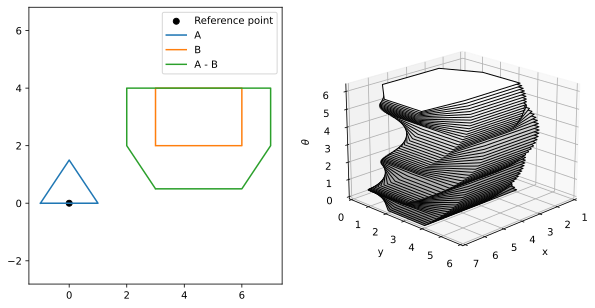

In [1]:
#this code shows the C-obstacle slices for a translating and rotating triangle
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

def convex_polygon_sort(A):
    """If A is a convex polygon, given by a list of points in CCW order
    but not necessarily sorted by increasing angle from the x axis,
    this will return a sorted version for use in convex_minkowski_sum.
    """
    i = np.argmin([v[1] for v in A])
    return A[i:] + A[:i]

def convex_minkowski_sum(A,B):
    """A and B are convex polygons, given by lists of points sorted
    by their angle about the minimum.  The output is a convex polygon
    in the same format.
    """
    aprogress = 0
    bprogress = 0
    res = []
    d = np.array([0,-1])
    res.append(A[aprogress] + B[bprogress])
    while aprogress < len(A) or bprogress < len(B):
        aindex = aprogress%len(A)
        bindex = bprogress%len(B)
        anext = (aprogress + 1)%len(A)
        bnext = (bprogress + 1)%len(B)
        #find minimum angle
        if np.dot(d, A[anext] + B[bindex] - res[-1]) > np.dot(d, A[aindex] + B[bnext] - res[-1]):
            res.append(A[anext] + B[bindex])
            d = res[-1] - res[-2]
            aprogress += 1
        else:
            res.append(A[aindex] + B[bnext])
            d = res[-1] - res[-2]
            bprogress += 1
    return res

#triangle
A = [np.array([-1,0]),np.array([1,0]),np.array([0,1.5])]
#rectangle
B = [np.array([3,2]),np.array([6,2]),np.array([6,4]),np.array([3,4])]
#minkowski sum
C = convex_minkowski_sum(convex_polygon_sort([-v for v in A]),convex_polygon_sort(B))

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.axis('equal')
ax1.scatter([0],[0],color='k',label='Reference point')
ax1.plot(np.array(A+[A[0]])[:,0],np.array(A+[A[0]])[:,1],label='A')
ax1.plot(np.array(B+[B[0]])[:,0],np.array(B+[B[0]])[:,1],label='B')
ax1.plot(np.array(C+[C[0]])[:,0],np.array(C+[C[0]])[:,1],label='A - B')
ax1.legend()

ax2.set_xlim(1,7)
ax2.set_ylim(0,6)
ax2.set_zlim(0,math.pi*2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel(r'$\theta$')
ax2.view_init(elev=20, azim=45)
Nslices = 60
for i in range(Nslices):
    u = float(i)/Nslices
    theta = u*math.pi*2
    R = np.array([[math.cos(theta),-math.sin(theta)],[math.sin(theta),math.cos(theta)]])
    RnA = [-np.dot(R,v) for v in A]
    C = convex_minkowski_sum(convex_polygon_sort(RnA),B)
    #output C at height theta
    tri = PolyCollection([np.array(C)])
    tri.set_color(colors.rgb2hex([0.5+0.5*u,0.5+0.5*u,0.5+0.5*u]))
    tri.set_edgecolor('k')
    ax2.add_collection3d(tri,zs=theta)
    
plt.show()

### Motion planning in SE(2)

Although some exact geometric techniques have been developed for planning in
SE(2), it is more common to adopt resolution-complete techniques to
handle the rotational DOF. As an example, grid search can be applied
fairly easily.

To apply grid search, the $\theta$ dimension is split into several
divisions on a grid over $[0,2\pi)$, in addition to the $x$ and $y$
dimensions. This gives a 3D grid graph that can be handled via search.
To properly handle the topology of SO(2), vertices just below
$\theta=2\pi$ are connected to the ones at $\theta=0$. Specifically,
suppose we have constructed a grid $(x_i,y_j,\theta_k)$ with indices
$i=1,\ldots,m$, $j=1,\ldots,n$, and $k=1,\ldots,p$. We have
$x_i = (i-1)\Delta x$, $y_j=(j-1)\Delta y$, and
$\theta_k= (k-1)\Delta \theta$, with $k=2\pi/p$. Then, for each
$i=1,\ldots,m$, $j=1,\ldots,n$ and $k=1,\ldots,p$, the graph has an edge
from each $(x_i,y_j,\theta_k)$ to $(x_{i+1},y_j,\theta_k)$ and
$(x_i,y_{j+1},\theta_k)$ (as long as that incremented index does not
exceed the limit), and $(x_i,y_j,\theta_{k+1\mod p})$. This leads to at
most 6 connections per vertex. Diagonal motions can also be added, which
results in 26-connected vertices (each vertex can be thought of being in
the center of a $3\times 3\times 3$ box).

Note that when applying search, a cost function needs to be assigned to
each edge. Because translation is measured in different units (say,
meters) than orientation (degrees or radians), it may not make much
sense to use Euclidean distance as the cost! As an extreme example, let
us assume that orientation is measured in degrees and translation in
meters, and suppose the robot would need to turn $90^\circ$ to pass
through a narrow gap, then rotate back $90^\circ$ to reach a goal 1 m
away. A planner using Euclidean distance would prefer to take a
roundabout path (up to 180 m longer!) to get to the goal without
reorientation. At a different extreme, let us assume that orientation is
measured in radians and translation in millimeters. Then, the robot
would prefer to pass through the gap even when there exists a slightly
longer path that does not require reorientation.

As a result it is usually prudent to adopt a *weighted metric* as cost,
such as the following:
$$c((x,y,\theta),(x^\prime,y^\prime,\theta^\prime)) = \sqrt{(x-x^\prime)^2+(y-y^\prime)^2+w_\theta diff(\theta,\theta^\prime)^2}.$$
Here, $diff$ is the geodesic angular distance in SO(2), and the weight
term $w_\theta$ should be chosen to balance the tradeoff between
translation and rotation. One reasonable choice is to set
$w_\theta = R^2$ where $R$ is the radius of the robot. For axis-aligned
motions, this weighted cost bounds the maximum distance that a point on
the robot could move during a straight line motion
$(x,y,\theta)\rightarrow (x^\prime,y^\prime,\theta^\prime)$.

Cell decomposition can also be extended in a resolution-complete fashion
to SE(2) by splitting $\theta$ into discrete values, and thinking of the
$(x,y)$ plane as a "layer" in 3D space. The C-obstacle for that layer
can be computed using Minkowski sums, and then its cell decomposition
computed. Then, an edge is added to connect cells on adjacent layers
whose $(x,y)$ projections overlap. This layered cell graph can then be
searched to connect any two points in SE(2).

Summary
-------

* Geometric motion planning methods can achieve completeness or resolution completeness in low-dimensional configuration spaces.
* The major classes of geometric planners are bug methods, grid search, visibility graph methods, and cell decomposition.
* Bug algorithms only use local information about obstacles and a small amount of memory to make decisions on-line.  They are sufficiently simple that their completeness and suboptimality can be analyzed using geometric reasoning.
* Grid search methods are quite general, can be applied to robots with arbitrary geometry, and can be extended to solve curvature-constrained problems using the state lattice approach.  They are resolution-complete, and their performance depends heavily on the grid resolution, and somewhat on the grid search heuristic.
* Visibility graph methods build a network of free paths between obstacle vertices. They are complete and optimal in 2D configuration spaces, but take at least $O(n^2)$ time and $O(n^2)$ space to build.
* Cell decomposition methods build a representation of the free space volume as a collection of simple geometric shapes. They can be complete, optimal, and constructed efficiently ($O(n \log n)$ for the trapezoidal decomposition).
* Translating robots with geometry can be converted into point robot problems by constructing C-obstacles. This can be done using the Minkowski difference operation.


Exercises
---------

1.  If all obstacles are convex and non-overlapping, is the Bug 1
    complete? If so, prove it. If not, produce a counterexample.

2.  Suppose that the bug had a $360^\circ$ distance sensor with some
    maximum range $R$ to detect the shape of obstacles around it.
    Specifically, suppose that it knows the shape of all obstacles in a
    circle of radius $R$. Could you modify Bug 1 so that the bug can
    reach the goal with a shorter path (when it terminates)? Bug 1
    should be equivalent to your new algorithm when $R=0$. Prove that
    your method produces paths of length no longer than paths produced
    by Bug 1.

3.  Prove that the minimum length path in a polygonal environment is
    either a straight line or passes through obstacle vertices. Then
    prove that the visibility graph method yields a path with minimum
    length. _Hint: consider whether a locally suboptimal path can be
    improved by "shortcutting" one of the corners of the path._

4.  Is grid search with 4-connected neighbors in a plane approximately
    optimal, provided that clearance is sufficiently large, and the
    length of an optimal path is greater than the grid resolution? If
    so, derive an approximation factor. If not, show a class of
    environments in which an arbitrarily poor approximation factor can
    be constructed.

5.  Create a modified `grid_search` algorithm in `rsbook_code.planning.grid_search`
    that accepts a `max_time` parameter that gives a maximum time budget
    for search.  After this amount of time has elapsed, no more nodes
    should be evaluated, and instead the algorithm should return the path
    leading to the explored node that got closest to the goal. 
    _Hint: you can raise an exception to break out of the search loop._

6.  The *medial axis* of the free space is the set of free points that are equidistant between exactly 
    two or more points on the obstacle boundary.  Draw the medial axis of the simple environment in Fig. 1.
    Could the medial axis be considered a form of roadmap?  Describe a path planning algorithm that could
    accept a medial axis as input and produce a path.

7.  Prove that the medial axis of a free space with polygonal obstacles consists of straight lines and
    parabolic arcs.  (Hint: recall the focus and directrix that define a parabola.)

8.  Give pseudocode for computing the Minkowski sum of two convex
    polygons in O($m+n$) time.

9.  What is the configuration space of two disk-shaped mobile robots
    that can translate in the plane? What C-space obstacles exist in
    this space, assuming they are not allowed to collide with the
    environment or each other? Extend your description of the C-space
    and C-space obstacles to $n$ robots.

10. Suppose $R$ is the maximum radius of the robot with respect to its
    reference point. Produce a cost metric for SE(2) that bounds the
    distance traveled by any point on the robot as it moves from
    $(x,y,\theta)\rightarrow (x^\prime,y^\prime,\theta^\prime)$ in a
    straight-line configuration-space motion.


## Interactive quiz

In [2]:
#This code must be run from the RoboticSystemsBook folder

# If you are running on Google Colab, uncomment the following code:
#
# %cd ~
# !git clone --depth 1 https://github.com/krishauser/RoboticSystemsBook
# %cd RoboticSystemsBook

from rsbook_code.assessment import quiz
quiz.show("geometric_motion_planning")

## Interactive examples

The following examples require [Numpy](https://numpy.org/) and [Matplotlib](https://matplotlib.org/) to be installed on your system, and for your Jupyter notebook to be run in the same folder containing this iPython notebook.

In [3]:
#If you are using Google Colab, first uncomment and run the following code

# %cd ~
# !git clone --depth 1 https://github.com/krishauser/RoboticSystemsBook
# %cd RoboticSystemsBook
# import rsbook_code

### Grid search

The following example shows a 2D grid search amongst obstacles.  The cost-to-come from the start is shown as a heatmap for all reached nodes in the grid.

Try changing the resolution to examine its effect on running time and solution quality. (0.5, 0.1, or 0.025 are good to try)

grid_search: search computed path with 28 nodes, cost 7.609087296526012 taking time: 0.06352496147155762


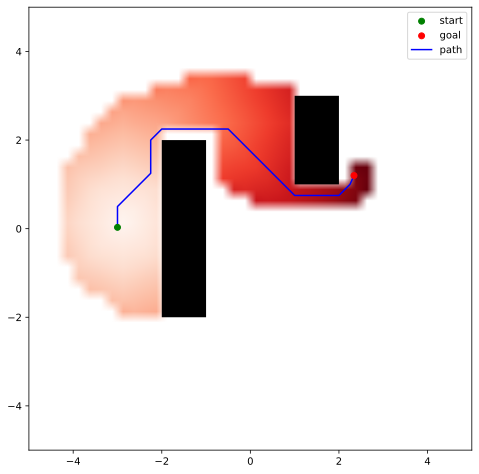

In [4]:
#Jupyter notebook must be run from this directory for this code to work.
%matplotlib inline

from rsbook_code.utilities import graph,example_graphs
from rsbook_code.planning import grid_search
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import math

#define search problem and obstacle boxes
xstart = (-3,0.03)
xgoal = (2.34,1.2)
xmin = [-5,-5]
xmax = [5,5]
resolution = 0.25
obstacles = [([-2,-2],[-1,2]),([1,1],[2,3])]
def in_obstacles(x):
    global obstacles
    for a,b in obstacles:
        if a[0] <= x[0] <= b[0] and a[1] <= x[1] <= b[1]:
            return True
    return False
path,d,p = grid_search.grid_search(xstart,xgoal,xmin,xmax,resolution=resolution,
                              obstacle_test = in_obstacles,
                              diagonals=True,implicit=True,
                              verbose=1)

#plot start, goal, and path
plt.figure(figsize=(8,8))
plt.xlim(xmin[0],xmax[0])
plt.ylim(xmin[1],xmax[1])
plt.scatter([xstart[0]],[xstart[1]],c='g',zorder=2,label='start')
plt.scatter([xgoal[0]],[xgoal[1]],c='r',zorder=2,label='goal')
if path is not None:
    plt.plot([v[0] for v in path],[v[1] for v in path],c='b',zorder=1,label='path')
#plot obstacles
for a,b in obstacles:
    patch = patches.Rectangle(a,b[0]-a[0],b[1]-a[1],facecolor='k')
    plt.gca().add_patch(patch)
#plot costs-to-come from start
distances = np.ones([int(math.floor((b-a)/resolution)) for (a,b) in zip(xmin,xmax)])*float('inf')
for (k,v) in d.items():
    if isinstance(k,str): continue
    distances[k] = v
plt.imshow(distances.T,cmap=plt.cm.Reds, interpolation='none', extent=[xmin[1],xmax[1],xmax[0],xmin[0]])
plt.legend()
plt.gca().set_aspect('equal', 'box')
plt.show()